# **Data Scientist Employee Attrition - Job Change of data Scientists**

### **Problem Statement**

A company that is active in Big data and data Science wants to hire data scientists among people who successfully pass some courses conducted by the company. Many people sign up for their training. The company wants to know which of these candidates want to work for the company after training or looking for new employment because it helps to reduce the cost and time as well as the quality of training or planning the courses and categorization of candidates. Information related to demographics, education and experience is provided by candidates during sign-up and enrollment.

This dataset is designed to understand the factors that lead a person to leave their current job, and it is hence useful for HR research. By building a model that uses the current credentials, demographics, and work experience related data, you will predict the probability that a candidate is looking for a new job, as well as interpret the main factors that affect an employee's decision whether to continue or attrite.

### **Data Description**

* **Enrollee_id:** Unique ID for candidate
* **City:** City code
* **City_development_index:** Development index of the city (scaled)
* **Gender:** Gender of candidate
* **Relevant_experience:** Relevant experience of candidate
* **Enrolled_university:** Type of University course enrolled if any
* **Education_level:** Education level of candidate
* **Major_discipline:** Education major discipline of candidate
* **Experience:** Candidate total experience in years
* **Company_size:** No of employees in current employer's company
* **Company_type:** Type of current employer
* **Last_new_job:** Difference in years between previous job and current job
* **Training_hours:** training hours completed
* **Target:** 0 – Not looking for job change, 1 – Looking for a job change

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, roc_curve, classification_report

import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import random
random.seed(1)
np.random.seed(1) 
tf.random.set_seed(1)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# reading the data
df = pd.read_csv('Data.csv')
display(df.head())
print(df.shape)

,Enrollee_id,City,City_development_index,Gender,Relevant_experience,Enrolled_university,Education_level,Major_discipline,Experience,Company_size,Company_type,Last_new_job,Training_hours,Target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0


(19158, 14)


In [6]:
# checking dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Enrollee_id             19158 non-null  int64  
 1   City                    19158 non-null  object 
 2   City_development_index  19158 non-null  float64
 3   Gender                  14650 non-null  object 
 4   Relevant_experience     19158 non-null  object 
 5   Enrolled_university     18772 non-null  object 
 6   Education_level         18698 non-null  object 
 7   Major_discipline        16345 non-null  object 
 8   Experience              19093 non-null  object 
 9   Company_size            13220 non-null  object 
 10  Company_type            13018 non-null  object 
 11  Last_new_job            18735 non-null  object 
 12  Training_hours          19158 non-null  int64  
 13  Target                  19158 non-null  int64  
dtypes: float64(1), int64(3), object(10)
me

In [7]:
# checking for duplicates
df.duplicated().sum()

0

In [8]:
# % of missing values in every column
np.round(df.isnull().sum() / df.isnull().count() * 100, 2)

Enrollee_id                0.00
City                       0.00
City_development_index     0.00
Gender                    23.53
Relevant_experience        0.00
Enrolled_university        2.01
Education_level            2.40
Major_discipline          14.68
Experience                 0.34
Company_size              30.99
Company_type              32.05
Last_new_job               2.21
Training_hours             0.00
Target                     0.00
dtype: float64

In [10]:
# value counts for the target variable
df.Target.value_counts()

0    14381
1     4777
Name: Target, dtype: int64

In [11]:
# statistical summary of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Enrollee_id,19158.0,16875.358179,9616.292592,1.000,8554.25,16982.500,25169.75,33380.000
City_development_index,19158.0,0.828848,0.123362,0.448,0.74,0.903,0.92,0.949
Training_hours,19158.0,65.366896,60.058462,1.000,23.00,47.000,88.00,336.000
Target,19158.0,0.249348,0.432647,0.000,0.00,0.000,0.00,1.000


In [12]:
# number of unique observations in each column
df.nunique()

Enrollee_id               19158
City                        123
City_development_index       93
Gender                        3
Relevant_experience           2
Enrolled_university           3
Education_level               5
Major_discipline              6
Experience                   22
Company_size                  8
Company_type                  6
Last_new_job                  6
Training_hours              241
Target                        2
dtype: int64

* Each value of the column 'Employee_id' is a unique identifier for an employee. Hence we can drop this column as it will not add any predictive power or value to the model.
* The 'City' column has 123 unique categories.

In [13]:
# value counts for each object type variable
for i in df.select_dtypes(include=['object']):
  print('unique values in {}:'.format(i))
  print(df[i].value_counts())
  print('-'*50)

unique values in City:
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_111       3
city_121       3
city_140       1
city_171       1
Name: City, Length: 123, dtype: int64
--------------------------------------------------
unique values in Gender:
Male      13221
Female     1238
Other       191
Name: Gender, dtype: int64
--------------------------------------------------
unique values in Relevant_experience:
Has relevent experience    13792
No relevent experience      5366
Name: Relevant_experience, dtype: int64
--------------------------------------------------
unique values in Enrolled_university:
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: Enrolled_university, dtype: int64
--------------------------------------------------
unique values in Education_level:
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School    

* The 'City' column has 123 unique categories, and the city with the highest number of employees is City 103.
* Over 90% of the employees in this dataset are males, so it is highly gender-skewed.
* Most of the employees (~70%) have relevant experience in data Science.
* 70% of the employees did not enroll in any of the courses.
* Most of the employees have a Bachelor's level of education (Graduation) but not more than that (~62% of the total number of employees). There are very few employees with Master's degrees and PhDs.
* Almost all the employees have previous experience (Related and Non-Related).
* ~75% of the employees are from private companies.

### Data Preprocessing

In [16]:
# dropping Enrollee_id column
df.drop(['Enrollee_id'], axis=1, inplace=True)
df.head()

,City,City_development_index,Gender,Relevant_experience,Enrolled_university,Education_level,Major_discipline,Experience,Company_size,Company_type,Last_new_job,Training_hours,Target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0
3,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0


## EDA
### Univariate Analysis

In [20]:
def hist_box(col):
  """ plots histogram and boxplot for the column passed as parameter"""
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios':(.15,.85)}, figsize=(10,5)) # divides image in two
  sns.boxplot(df[col], ax=ax_box, showmeans=True) # boxplot of the column
  sns.histplot(df[col], ax=ax_hist, kde=True) # histplot of the column
  ax_hist.axvline(df[col].mean(), linestyle='--', color='green') # green line in the mean value of the column
  ax_hist.axvline(df[col].median(), linestyle='--', color='orange') # orange line the median of the column
  ax_box.set(xlabel=col)
  plt.show()

#### Observations on City_development_index

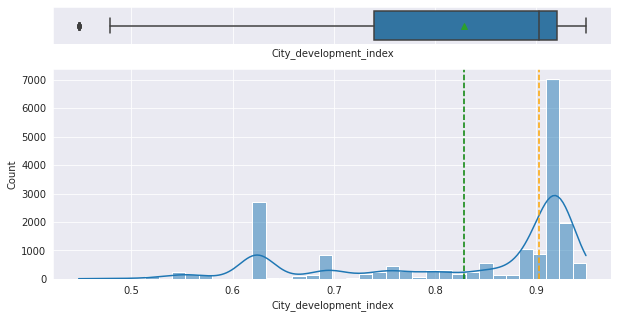

In [25]:
hist_box('City_development_index')

* From the above plot, we observe that there are many people from cities having a development index more than 0.9. 

#### Observations on Training_hours

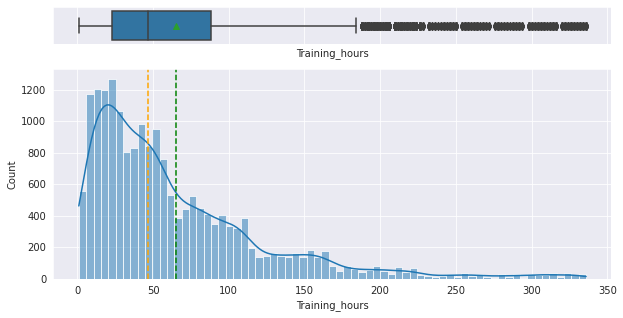

In [26]:
hist_box('Training_hours')

* From the plot, we observe that the measures of central tendency with respect to training hours seem to be 70, despite a maximum value over 300 hours. So most of the people in this dataset have undergone training for less than 100 hours.

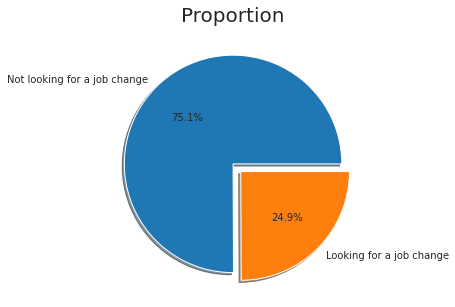

In [38]:
fig1, ax1 = plt.subplots(figsize=(7, 5))
ax1.pie(df.Target.value_counts(), explode=(0,0.1), labels=['Not looking for a job change', 'Looking for a job change'], autopct='%.1f%%', shadow=True)
plt.title('Proportion', size=20)
plt.show()

* This pie chart shows that the actual distribution of classes is itself imbalanced for the target variable.
* Only ~25% of the employees in this dataset are actually looking for a job change.

Hence, this dataset and problem statement represent an example of Imbalanced Classification, which has unique challenges in comparison to performing classification over balanced target variables.

### Bivariate Analysis

#### Target vs Gender

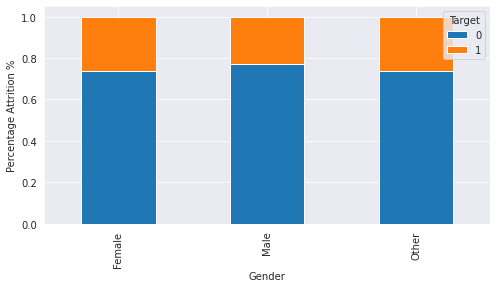

In [44]:
pd.crosstab(df.Gender, df.Target, normalize='index').plot(kind='bar', stacked=True, figsize=(8,4))
plt.ylabel('Percentage Attrition %')
plt.show()

* From the above plot, it is observed that the likelihood of the employee choosing a job switch does not depend on their gender.

#### Targer vs Relevant Experiense

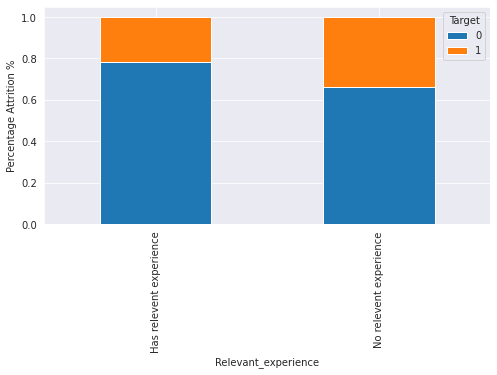

In [47]:
pd.crosstab(df.Relevant_experience, df.Target, normalize='index').plot(kind='bar', stacked=True, figsize=(8,4))
plt.ylabel('Percentage Attrition %')
plt.show()

* From the above plot, we see that employees from Non-relevant experience are more likely to be switching their job.

#### Target vs Enrolled_university

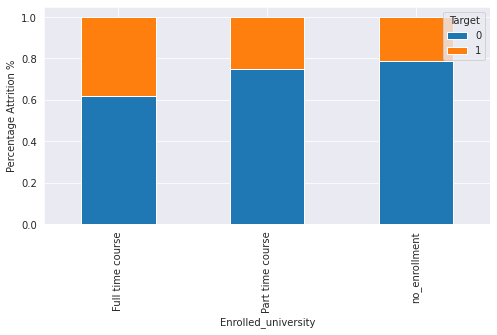

In [48]:
pd.crosstab(df.Enrolled_university, df.Target, normalize='index').plot(kind='bar', stacked=True, figsize=(8,4))
plt.ylabel('Percentage Attrition %')
plt.show()

* Employees who have taken full-time courses in universities are the ones who are more likely to be trying to switch jobs.

### Target vs Education_level

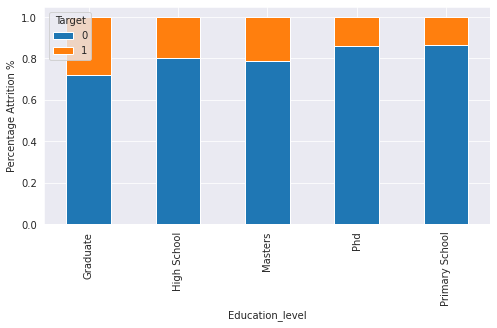

In [49]:
pd.crosstab(df.Education_level, df.Target, normalize='index').plot(kind='bar', stacked=True, figsize=(8,4))
plt.ylabel('Percentage Attrition %')
plt.show()

* Employees who completed Graduation and Master's degrees are more likely to be trying to switch their jobs. 

### Target vs Major_discipline

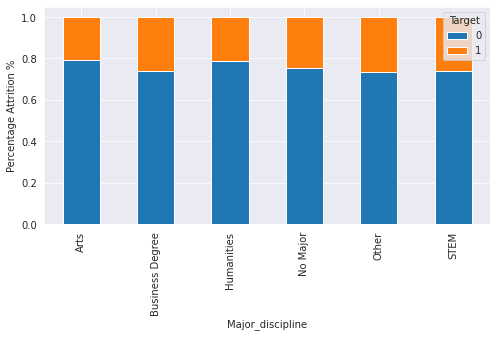

In [51]:
pd.crosstab(df.Major_discipline, df.Target, normalize='index').plot(kind='bar', stacked=True, figsize=(8,4))
plt.ylabel('Percentage Attrition %')
plt.show()

* Employees who took STEM or Business Degrees as their major discipline are slightly more likely to change their job.

### Target vs Experience

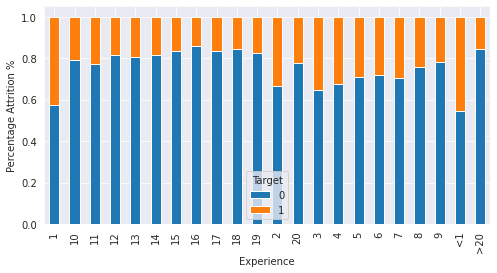

In [52]:
pd.crosstab(df.Experience, df.Target, normalize='index').plot(kind='bar', stacked=True, figsize=(8,4))
plt.ylabel('Percentage Attrition %')
plt.show()

* From the above plot, it's clear that employees having a work experience of less than 3 years are trying to switch their jobs.

### Target vs Last_new_job

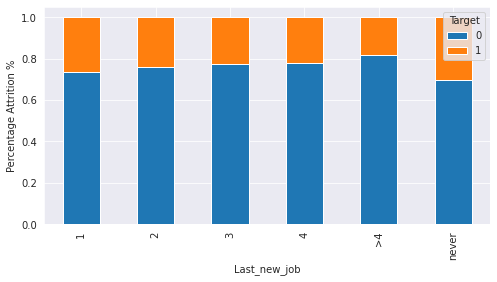

In [53]:
pd.crosstab(df.Last_new_job, df.Target, normalize='index').plot(kind='bar', stacked=True, figsize=(8,4))
plt.ylabel('Percentage Attrition %')
plt.show()

* Employees who have never switched their job before are the most likely to be looking for a job change.

### Targer vs Company_size

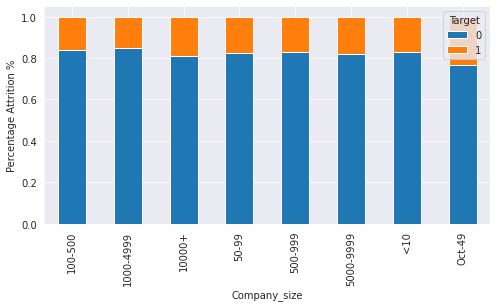

In [55]:
pd.crosstab(df.Company_size, df.Target, normalize='index').plot(kind='bar', stacked=True, figsize=(8,4))
plt.ylabel('Percentage Attrition %')
plt.show()

- Company size doesn't affect Attrition rate


In [59]:
### dropping columns that doesn't give predictive performance
df.drop(['City', 'Company_size', 'Gender'], axis=1, inplace=True)

In [60]:
df.head()

,City_development_index,Relevant_experience,Enrolled_university,Education_level,Major_discipline,Experience,Company_type,Last_new_job,Training_hours,Target
0,0.920,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,1,36,1
1,0.776,No relevent experience,no_enrollment,Graduate,STEM,15,Pvt Ltd,>4,47,0
2,0.624,No relevent experience,Full time course,Graduate,STEM,5,NaN,never,83,0
3,0.789,No relevent experience,NaN,Graduate,Business Degree,<1,Pvt Ltd,never,52,1
4,0.767,Has relevent experience,no_enrollment,Masters,STEM,>20,Funded Startup,4,8,0


In [62]:
# separating categorical varaibles for imputation
cat_col_df = df.drop(['City_development_index', 'Training_hours', 'Target'], axis=1)

### Missing value imputation
* We will impute the missing values in columns using their mode.

In [63]:
# Separating dependent and independent variables
X = df.drop(['Target'], axis=1)
Y = df['Target']

In [65]:
# Spliting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [66]:
# checking null values in training set
X_train.isnull().sum()

City_development_index       0
Relevant_experience          0
Enrolled_university        317
Education_level            362
Major_discipline          2258
Experience                  50
Company_type              4881
Last_new_job               343
Training_hours               0
dtype: int64

In [68]:
# imputing null values in training and testing sets
imputer_mode = SimpleImputer(strategy='most_frequent')
X_train[["Enrolled_university","Education_level","Major_discipline","Experience","Company_type","Last_new_job"]] = imputer_mode.fit_transform(X_train[["Enrolled_university","Education_level","Major_discipline","Experience","Company_type","Last_new_job"]])
X_test[["Enrolled_university","Education_level","Major_discipline","Experience","Company_type","Last_new_job"]] = imputer_mode.transform(X_test[["Enrolled_university","Education_level","Major_discipline","Experience","Company_type","Last_new_job"]])

In [69]:
print(X_train.isna().sum())
print('-'*50)
print(X_test.isna().sum())

City_development_index    0
Relevant_experience       0
Enrolled_university       0
Education_level           0
Major_discipline          0
Experience                0
Company_type              0
Last_new_job              0
Training_hours            0
dtype: int64
--------------------------------------------------
City_development_index    0
Relevant_experience       0
Enrolled_university       0
Education_level           0
Major_discipline          0
Experience                0
Company_type              0
Last_new_job              0
Training_hours            0
dtype: int64


### Encoding Categorical Columns
* We will be using the Label Encoding technique to encode the values of the categorical columns in this dataset.

In [71]:
# create function to fit and transform the label encoder
def label_encode_columns(df, columns):
  encoders = {}
  for col in columns:
    le = LabelEncoder().fit(df[col])
    df[col] = le.transform(df[col])
    encoders[col] = le
  return df, encoders

# create thte function to take in the fitted encoders and transform the scoring dataset
def label_encode_columns_w_fit_encoders(df, columns, encoders):
  for col in columns:
    le = encoders.get(col)
    df[col] = le.transform(df[col])
  return df

# define the columns we want to encode
encode_columns = ['Relevant_experience','Enrolled_university','Education_level','Major_discipline','Experience','Company_type','Last_new_job']

# Fit and transform the training dataset, returning both the new training dataset and the fitted encoders to use on the scoring dataset
X_train, encoders = label_encode_columns(df=X_train, columns=encode_columns)

# Transform the scoring dataset using the encoders we fit previously
X_test = label_encode_columns_w_fit_encoders(df=X_test, columns=encode_columns, encoders=encoders)


In [72]:
X_train.head()

,City_development_index,Relevant_experience,Enrolled_university,Education_level,Major_discipline,Experience,Company_type,Last_new_job,Training_hours
17855,0.624,0,2,0,5,1,5,0,90
17664,0.920,1,2,4,5,15,5,5,15
13404,0.896,0,2,0,5,3,2,4,36
13366,0.920,0,2,0,5,15,1,0,53
15670,0.855,0,0,0,5,15,5,0,158


In [73]:
# checking the shape of train and test sets
print(X_train.shape)
print(X_test.shape)

(15326, 9)
(3832, 9)


## **Model Building**
#### **A model can make wrong predictions in the following ways:**
* Predicting an employee is looking for a job, when he/she is not looking for it. 
* Predicting an employee is not looking for a job, when he/she is in fact looking for one.

#### **Which case is more important?**

Both cases are actually important for the purposes of this case study. Not giving a chance to a deserving employee (by wrongly classifying them as likely to attrite) might lead to decreased productivity, and the company might lose a good employee affecting the organization's growth. However, giving chances to a non-deserving employee (as they are likely to attrite) would lead to a financial loss for the company, and giving such employees an increased amount of responsibility might again affect the company's growth.

#### **How to reduce this loss i.e need to reduce False Negatives as well as False Positives?**

Since both errors are important for us to minimize, the company would want the F1 Score evaluation metric to be maximized/ Hence, the focus should be on increasing the F1 score rather than focusing on just one metric i.e. Recall or Precision.

**Also, let's create a function to calculate and visualize the confusion matrix so that we don't have to rewrite the same code repeatedly for each model.**

In [86]:
# function to make confusion matrix
def make_confusion_matrix(cf, 
                          group_names=None, 
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
  """
  This function will make a pretty plot of an sklearn confusion matrix
  """

  # code to generate text inside each square
  blanks = ['' for i in range(cf.size)]

  if group_names and len(group_names) == cf.size:
    group_labels = ['{}\n'.format(value) for value in group_names]
  else:
    group_labels = blanks

  if count:
    group_counts = ['{0:0.0f}\n'.format(value) for value in cf.flatten()]
  else:
    group_counts = blanks

  if percent:
    group_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
  else:
    group_percentages = blanks

  box_labels = [f'{v1}{v2}{v3}'.strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
  box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

  # code to generate summary statistics & text for summary statistics
  if sum_stats:
    accuracy = np.trace(cf) / float(np.sum(cf))

  # set figure parameters according to other arguments
  if figsize == None:
    figsize = plt.rcParams.get('figure.figsize')

  if xyticks == False:
    categories = False

  # make heatmap visualization
  plt.figure(figsize=figsize)
  sns.heatmap(cf, annot=box_labels,fmt='',cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

  if title:
    plt.title(title)


## Building Neural Network

### Model 1

In [76]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [78]:
# initializing the ANN
model = Sequential()

# The amount of nodes in hidden layer should be the average of input and output and output layers, in this case 64
# This adds the input layer (input dimension) and the first hidden layer (units)
model.add(Dense(activation='relu', input_dim=9, units=64))

# Adding hidden layer
model.add(Dense(32, activation='relu'))

# Adding the output layer
# output of 1 node (sigmoid because of probability)
model.add(Dense(1, activation='sigmoid'))

In [79]:
# Create optimizer with default learning rate
# compile the model
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.5506 - accuracy: 0.7505 - val_loss: 0.6341 - val_accuracy: 0.7515
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.5503 - accuracy: 0.7504 - val_loss: 0.5461 - val_accuracy: 0.7515
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.5478 - accuracy: 0.7507 - val_loss: 0.5429 - val_accuracy: 0.7518
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.5499 - accuracy: 0.7502 - val_loss: 0.5456 - val_accuracy: 0.7515
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.5493 - accuracy: 0.7507 - val_loss: 0.5836 - val_accuracy: 0.7479
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.5493 - accuracy: 0.7502 - val_loss: 0.5873 - val_accuracy: 0.7515
Epoch 7/50
384/384 [==============================] - 1s 2ms/step - loss: 0.5483 - accuracy: 0.7507 - val_loss: 0.5630 - val_accuracy: 0.7518
Epoch 

120/120 [==============================] - 0s 1ms/step - loss: 0.5389 - accuracy: 0.7508


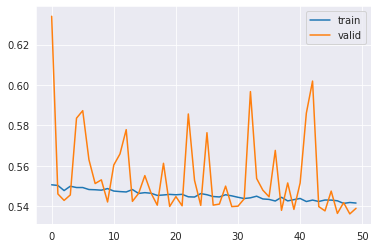

In [83]:
# capturing learning per epoch
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(('train', 'valid'), loc=0)

# printing results
results = model.evaluate(X_test, y_test)

There is noise in the loss behavior here. Sometimes, the loss function fluctuates a lot during training, which makes the convergence slow. These fluctuations are due to the nature of Stochastic Gradient Descent that produces noisy updates in the parameters. 

### Let's check the other metrics.

In [84]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

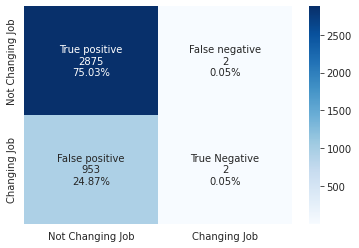

In [87]:
# calculating the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['True positive', 'False negative', 'False positive', 'True Negative']
categories = ['Not Changing Job', 'Changing Job']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

Here, the 0.05% of False Negatives is because we gave 0.5 as the threshold to the model, and as this is an imbalanced dataset, we should calculate the threshold using the AUC-ROC curve. 

In [88]:
from sklearn import metrics
cr = metrics.classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      2877
           1       0.50      0.00      0.00       955

    accuracy                           0.75      3832
   macro avg       0.63      0.50      0.43      3832
weighted avg       0.69      0.75      0.64      3832



As you can see, the above model has a good accuracy but a poor F1-score. This could be due to the imbalanced dataset. We observe that the False positive rates are also high, which should be considerably lower. 

1) **Imbalanced dataset**: As you have seen in the EDA, this dataset is imbalanced, and it contains more examples that belong to the **0** class.

2) **Decision Threshold**: Due to the imbalanced dataset, we can use ROC-AUC to find the optimal threshold and use the same for prediction.


### Let's try to change the optimizer, tune the decision threshold, increase the layers and configure some other hyperparameters accordingly, in order to improve the model's performance.

### Model 2

In [89]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [90]:
model2 = Sequential()

model2.add(Dense(256, activation='relu', kernel_initializer='he_uniform', input_dim=X_train.shape[1]))
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(0.001)
model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [91]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2560      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 45,825
Trainable params: 45,825
Non-trainable params: 0
_________________________________________________________________


In [92]:
history2 = model2.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
192/192 [==============================] - 2s 6ms/step - loss: 1.2936 - accuracy: 0.6872 - val_loss: 0.6399 - val_accuracy: 0.6279
Epoch 2/50
192/192 [==============================] - 1s 5ms/step - loss: 0.7389 - accuracy: 0.7110 - val_loss: 0.5787 - val_accuracy: 0.7146
Epoch 3/50
192/192 [==============================] - 1s 5ms/step - loss: 0.6730 - accuracy: 0.7163 - val_loss: 0.6370 - val_accuracy: 0.7511
Epoch 4/50
192/192 [==============================] - 1s 5ms/step - loss: 0.6079 - accuracy: 0.7294 - val_loss: 0.5534 - val_accuracy: 0.7515
Epoch 5/50
192/192 [==============================] - 1s 5ms/step - loss: 0.5767 - accuracy: 0.7374 - val_loss: 0.6103 - val_accuracy: 0.7498
Epoch 6/50
192/192 [==============================] - 1s 5ms/step - loss: 0.5856 - accuracy: 0.7362 - val_loss: 0.5581 - val_accuracy: 0.7524
Epoch 7/50
192/192 [==============================] - 1s 5ms/step - loss: 0.5679 - accuracy: 0.7419 - val_loss: 0.5364 - val_accuracy: 0.7518
Epoch 

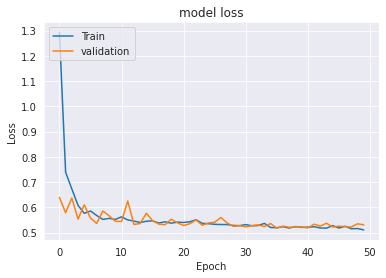

In [94]:
# plotting train loss vs validation loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

As we increased the depth of the neural network and changed the optimizer to Adam, we can see smoother loss curves for both train and validation.

best threshold=0.184945, G-Mean=0.686


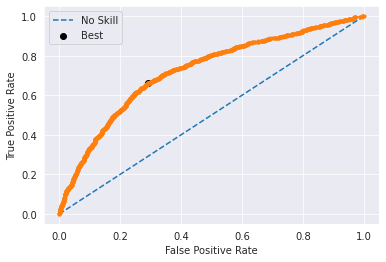

In [98]:
# predict probabilities
yhat2 = model2.predict(X_test)
# keep probabilities for the positive outcome only
yhat2 = yhat2[:, 0]
# calculate roc curves
fpr, tpr, thresholds2 = roc_curve(y_test, yhat2)
# calculate the g-mean for each threshold
gmeans2 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans2)
print('best threshold=%f, G-Mean=%.3f' % (thresholds2[ix], gmeans2[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

**Let's tune the threshold using ROC-AUC**

There are many ways we could locate the threshold with the optimal balance between false positive and true positive rates. 

Firstly, the true positive rate is called the Sensitivity. The inverse of the false-positive rate is called the Specificity.

**Sensitivity = True Positive / (True Positive + False Negative)**

**Specificity = True Negative / (False Positive + True Negative)**

Where:

Sensitivity = True Positive Rate

Specificity = 1 – False Positive Rate

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

**G-Mean = sqrt(Sensitivity * Specificity)**

One approach would be to test the model with each threshold returned from the call roc_auc_score(),and select the threshold with the **largest G-Mean value.**

In [99]:
y_pred_e2 = model2.predict(X_test)
y_pred_e2 = (y_pred_e2 > thresholds2[ix])
y_pred_e2

array([[False],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [False]])

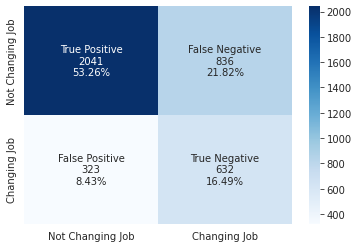

In [100]:
#Calculating the confusion matrix 
from sklearn.metrics import confusion_matrix
cm1=confusion_matrix(y_test, y_pred_e2)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Changing Job','Changing Job']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [101]:
#Accuracy as per the classification report 
from sklearn import metrics
cr=metrics.classification_report(y_test,y_pred_e2)
print(cr)

              precision    recall  f1-score   support

           0       0.86      0.71      0.78      2877
           1       0.43      0.66      0.52       955

    accuracy                           0.70      3832
   macro avg       0.65      0.69      0.65      3832
weighted avg       0.76      0.70      0.71      3832



As the number of layers in the neural network has increased, we can see that the macro F1 score has increased, and the False Negative percentage has decreased. 

### Now let's try to use the Batch Normalization technique and check to see if we can increase the F1 score. 

### Model 3

In [102]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [103]:
model2 = Sequential()
model2.add(Dense(128,activation='relu',input_dim = X_train.shape[1]))
model2.add(BatchNormalization())
model2.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
model2.add(Dense(1, activation = 'sigmoid'))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [104]:
optimizer = tf.keras.optimizers.Adam(0.001)
model2.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [105]:
history_2 = model2.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.2)

Epoch 1/50
192/192 [==============================] - 3s 6ms/step - loss: 0.5698 - accuracy: 0.7403 - val_loss: 0.5690 - val_accuracy: 0.7515
Epoch 2/50
192/192 [==============================] - 1s 5ms/step - loss: 0.5437 - accuracy: 0.7497 - val_loss: 0.5340 - val_accuracy: 0.7567
Epoch 3/50
192/192 [==============================] - 1s 8ms/step - loss: 0.5268 - accuracy: 0.7547 - val_loss: 0.5257 - val_accuracy: 0.7551
Epoch 4/50
192/192 [==============================] - 1s 3ms/step - loss: 0.5142 - accuracy: 0.7573 - val_loss: 0.5059 - val_accuracy: 0.7613
Epoch 5/50
192/192 [==============================] - 1s 3ms/step - loss: 0.5089 - accuracy: 0.7608 - val_loss: 0.5084 - val_accuracy: 0.7626
Epoch 6/50
192/192 [==============================] - 1s 3ms/step - loss: 0.5065 - accuracy: 0.7604 - val_loss: 0.5351 - val_accuracy: 0.7560
Epoch 7/50
192/192 [==============================] - 1s 3ms/step - loss: 0.5030 - accuracy: 0.7630 - val_loss: 0.5133 - val_accuracy: 0.7531
Epoch 

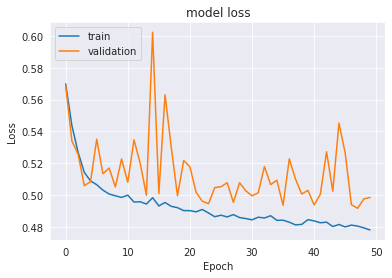

In [106]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Unfortunately, from the above plot we observe that there is a lot of noise in the model, and it and seems to have overfitted on the training data because there is a significant difference in performance between train and validation.

Best Threshold=0.218554, G-Mean=0.701


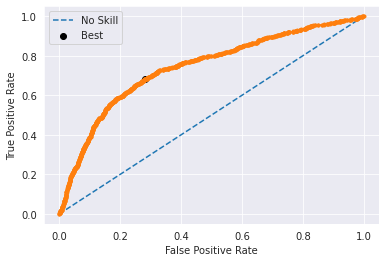

In [108]:
# predict probabilities
yhat2 = model2.predict(X_test)
# keep probabilities for the positive outcome only
yhat2 = yhat2[:, 0]
# calculate roc curves
fpr, tpr, thresholds2 = roc_curve(y_test, yhat2)
# calculate the g-mean for each threshold
gmeans2 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans2)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds2[ix], gmeans2[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [109]:
y_pred_e2=model2.predict(X_test)
y_pred_e2 = (y_pred_e2 > thresholds2[ix])
y_pred_e2

array([[False],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [False]])

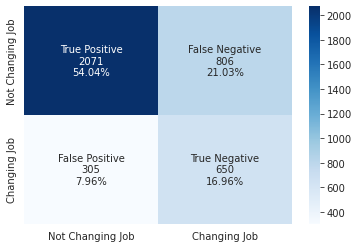

In [110]:
#Calculating the confusion matrix 
from sklearn.metrics import confusion_matrix
cm2=confusion_matrix(y_test, y_pred_e2)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Changing Job','Changing Job']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [111]:
#Accuracy as per the classification report 
from sklearn import metrics
cr2=metrics.classification_report(y_test,y_pred_e2)
print(cr2)

              precision    recall  f1-score   support

           0       0.87      0.72      0.79      2877
           1       0.45      0.68      0.54       955

    accuracy                           0.71      3832
   macro avg       0.66      0.70      0.66      3832
weighted avg       0.77      0.71      0.73      3832



The Train and Validation curves seem to show overfitting despite having a good F1 score and a low False Negative rate. 

### Let's try to use the Dropout technique and check to see if it can reduce the False Negative rate. 

### Model 4

In [112]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [113]:
model3 = Sequential()
model3.add(Dense(256,activation='relu',input_dim = X_train.shape[1]))
model3.add(Dropout(0.2))
model3.add(Dense(128,activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(32,activation='relu'))
model3.add(Dense(1, activation = 'sigmoid'))

In [114]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2560      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [115]:
optimizer = tf.keras.optimizers.Adam(0.001)
model3.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [116]:
history_3 = model3.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.2)

Epoch 1/50
192/192 [==============================] - 4s 9ms/step - loss: 0.6613 - accuracy: 0.7186 - val_loss: 0.5839 - val_accuracy: 0.7515
Epoch 2/50
192/192 [==============================] - 2s 9ms/step - loss: 0.5803 - accuracy: 0.7481 - val_loss: 0.5713 - val_accuracy: 0.7515
Epoch 3/50
192/192 [==============================] - 1s 7ms/step - loss: 0.5679 - accuracy: 0.7498 - val_loss: 0.5597 - val_accuracy: 0.7515
Epoch 4/50
192/192 [==============================] - 1s 5ms/step - loss: 0.5632 - accuracy: 0.7502 - val_loss: 0.5584 - val_accuracy: 0.7515
Epoch 5/50
192/192 [==============================] - 1s 6ms/step - loss: 0.5596 - accuracy: 0.7504 - val_loss: 0.5564 - val_accuracy: 0.7515
Epoch 6/50
192/192 [==============================] - 1s 3ms/step - loss: 0.5605 - accuracy: 0.7504 - val_loss: 0.5569 - val_accuracy: 0.7515
Epoch 7/50
192/192 [==============================] - 1s 4ms/step - loss: 0.5550 - accuracy: 0.7504 - val_loss: 0.5466 - val_accuracy: 0.7515
Epoch 

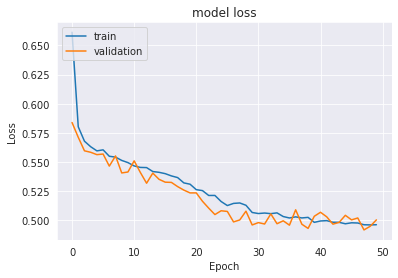

In [118]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

From the above plot, we observe that both the curves - train and validation are smooth.

Best Threshold=0.205984, G-Mean=0.705


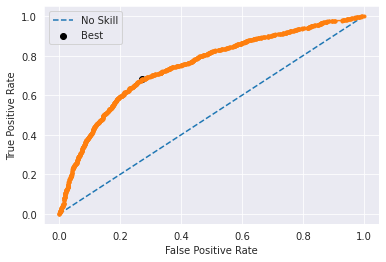

In [117]:
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat3 = model3.predict(X_test)
# keep probabilities for the positive outcome only
yhat3 = yhat3[:, 0]
# calculate roc curves
fpr, tpr, thresholds3 = roc_curve(y_test, yhat3)
# calculate the g-mean for each threshold
gmeans3 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans3)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds3[ix], gmeans3[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [119]:
y_pred_e3=model3.predict(X_test)
y_pred_e3 = (y_pred_e3 > thresholds3[ix])
y_pred_e3

array([[False],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [False]])

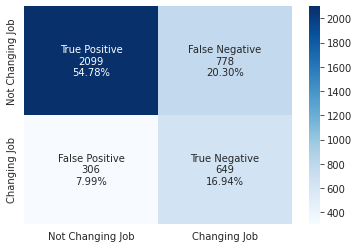

In [120]:
#Calculating the confusion matrix 
from sklearn.metrics import confusion_matrix
cm3=confusion_matrix(y_test, y_pred_e3)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Changing Job','Changing Job']
make_confusion_matrix(cm3, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [121]:
#Accuracy as per the classification report 
from sklearn import metrics
cr3=metrics.classification_report(y_test,y_pred_e3)
print(cr3)

              precision    recall  f1-score   support

           0       0.87      0.73      0.79      2877
           1       0.45      0.68      0.54       955

    accuracy                           0.72      3832
   macro avg       0.66      0.70      0.67      3832
weighted avg       0.77      0.72      0.73      3832



The Dropout technique helped the model reduce the loss function of both train and validation. The F1 score also seems to be fine, with a decrease in the False Negative rate.

## Additional Content (Optional)
Now, let's try to use some of the Hyperparameter Optimization techniques such as RandomizedSearchCV and Keras Tuner to increase the F1 score of the model.

### Model 5

#### **Random Search CV**

Some important hyperparameters to look out for while optimizing neural networks are:

* Type of Architecture

* Number of Layers

* Number of Neurons in a layer

* Regularization hyperparameters

* Learning Rate

* Type of Optimizer

* Dropout Rate

In [122]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [123]:
def create_model_v4(lr,batch_size):  
    np.random.seed(1337)
    model = Sequential()
    model.add(Dense(256,activation='relu',input_dim = X_train.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu')) 
    model.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

We are using Random search to optimize two hyperparameters - **Batch size** & **Learning Rate**.

You can also optimize other hyperparameters as mentioned above.




In [124]:
keras_estimator = KerasClassifier(build_fn=create_model_v4, verbose=1)
# define the grid search parameters
param_random = {
    'batch_size':[32, 64, 128],
    "lr":[0.01,0.1,0.001],}

kfold_splits = 3
random= RandomizedSearchCV(estimator=keras_estimator,  
                    verbose=1,
                    cv=kfold_splits,  
                    param_distributions=param_random,n_jobs=-1)

In [125]:
random_result = random.fit(X_train, y_train,validation_split=0.2,verbose=1) 

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Fitting 3 folds for each of 9 candidates, totalling 27 fits
384/384 [==============================] - 3s 6ms/step - loss: 0.6440 - accuracy: 0.7415 - val_loss: 0.5613 - val_accuracy: 0.7515
Best: 0.750620 using {'lr': 0.01, 'batch_size': 32}


The best model is with the following configuration: 

( It may vary each time the code runs ) 

**Result of Random Search**

{'batch_size': 32, 'learning_rate": 0.01}

Let's create the final model with the above mentioned configuration

In [126]:
estimator_v4=create_model_v4(batch_size=random_result.best_params_['batch_size'],lr=random_result.best_params_['lr'])

estimator_v4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               2560      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [127]:
optimizer = tf.keras.optimizers.Adam(random_result.best_params_['lr'])
estimator_v4.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_4=estimator_v4.fit(X_train, y_train, epochs=50, batch_size = 64, verbose=1,validation_split=0.2)

Epoch 1/50
192/192 [==============================] - 2s 4ms/step - loss: 0.6643 - accuracy: 0.7405 - val_loss: 0.5677 - val_accuracy: 0.7515
Epoch 2/50
192/192 [==============================] - 1s 4ms/step - loss: 0.5649 - accuracy: 0.7502 - val_loss: 0.5619 - val_accuracy: 0.7515
Epoch 3/50
192/192 [==============================] - 1s 4ms/step - loss: 0.5602 - accuracy: 0.7503 - val_loss: 0.5537 - val_accuracy: 0.7515
Epoch 4/50
192/192 [==============================] - 1s 4ms/step - loss: 0.5583 - accuracy: 0.7504 - val_loss: 0.5482 - val_accuracy: 0.7515
Epoch 5/50
192/192 [==============================] - 1s 3ms/step - loss: 0.5556 - accuracy: 0.7504 - val_loss: 0.5541 - val_accuracy: 0.7515
Epoch 6/50
192/192 [==============================] - 1s 4ms/step - loss: 0.5544 - accuracy: 0.7498 - val_loss: 0.5463 - val_accuracy: 0.7515
Epoch 7/50
192/192 [==============================] - 1s 4ms/step - loss: 0.5505 - accuracy: 0.7500 - val_loss: 0.5392 - val_accuracy: 0.7515
Epoch 

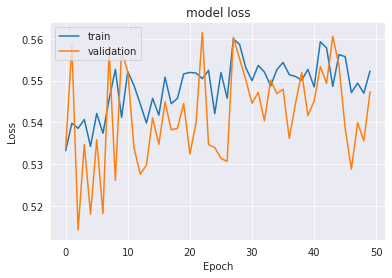

In [129]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

From the above plot, we observe that there is noise in the training behavior of the model.

Best Threshold=0.283784, G-Mean=0.604


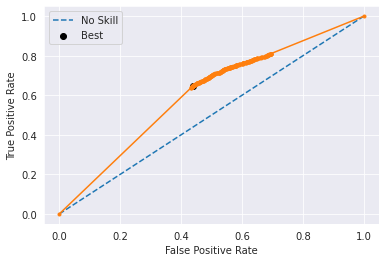

In [131]:
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat4 = estimator_v4.predict(X_test)
# keep probabilities for the positive outcome only
yhat4 = yhat4[:, 0]
# calculate roc curves
fpr, tpr, thresholds4 = roc_curve(y_test, yhat4)
# calculate the g-mean for each threshold
gmeans4 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans4)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds4[ix], gmeans4[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [132]:
y_pred_e4=estimator_v4.predict(X_test)
y_pred_e4 = (y_pred_e4 > thresholds4[ix])
y_pred_e4

array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [False]])

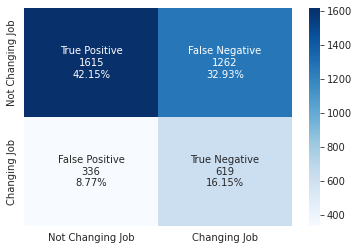

In [133]:
#Calculating the confusion matrix 
from sklearn.metrics import confusion_matrix
cm4=confusion_matrix(y_test, y_pred_e4)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Changing Job','Changing Job']
make_confusion_matrix(cm4, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [134]:
#Accuracy as per the classification report 
from sklearn import metrics
cr4=metrics.classification_report(y_test,y_pred_e4)
print(cr4)

              precision    recall  f1-score   support

           0       0.83      0.56      0.67      2877
           1       0.33      0.65      0.44       955

    accuracy                           0.58      3832
   macro avg       0.58      0.60      0.55      3832
weighted avg       0.70      0.58      0.61      3832



- Hyperparameter tuning is used here to get a better F1 score, but the F1 score may differ each time. 

- Other hyperparameters can also be tuned to get better performance on the metrics. 

- Here, the F1 score of the model has decreased in comparison to the previous best performance, as Random Search CV will choose the hyperparameters randomly, and hence has a very low chance of finding a highly optimal configuration. 

- So, our final model here can be **Model 4**, which uses the Dropout regularization technique and works on the imbalanced dataset.

### Business Recommendations
* The HR department of the company can deploy the final model from this exercise to identify with a reasonable degree of accuracy whether an employee is likely to switch jobs or not, and this process seems to be easier and more time-efficient than other methods.